In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show

## Loading Data

In [2]:
nm_shp = gpd.read_file("JamaicaNonmangroveLabels.shp")
m_shp = gpd.read_file("JamaicaMangroveLabelsFixed.shp")

nm_geoms = nm_shp.geometry
m_geoms = m_shp.geometry

In [3]:
src = rasterio.open("JamaicaFeaturesNoSAR.tif") 
mask_src = rasterio.open("JamaicaImageMask.tif") 
m_image, m_transform = mask(src, m_geoms, crop=True) 
nm_image, nm_transform = mask(src, nm_geoms, crop=True)

#Getting mask for each class
mmask, mmask_transform = mask(mask_src, m_geoms, crop=True)
nmmask, nmmask_transform = mask(mask_src, nm_geoms, crop=True)

# Reshaping Data

In [6]:
m_idx = np.squeeze(((reshape_as_image(mmask) == 1)), axis=-1) 
nm_idx = np.squeeze((reshape_as_image(nmmask) == 1), axis=-1)

In [7]:
m_pix = reshape_as_image(m_image)[m_idx]
nm_pix = reshape_as_image(nm_image)[nm_idx]

m_pix = m_pix[np.all(m_pix != 0, axis=1)]
nm_pix = nm_pix[np.all(nm_pix != 0, axis=1)]

In [8]:
x = np.concatenate((m_pix, nm_pix), axis = 0)
y = np.concatenate((np.zeros((m_pix.shape[0]))+1, np.zeros((nm_pix.shape[0]))))

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# XGBoost Training

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [11]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [12]:
#%%time
xgb_pred = xgb_model.predict(x_test)

# Feature Importance with XGBoost

In [13]:
#importance scores
xgb_model.feature_importances_

array([0.01492495, 0.00713361, 0.01835813, 0.00992914, 0.13760589,
       0.4628484 , 0.02610593, 0.07358813, 0.24950585], dtype=float32)

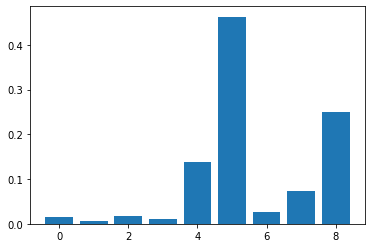

In [14]:
#plot the importance score
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.show()

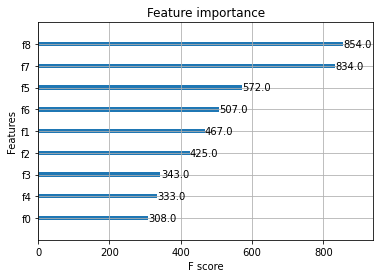

In [15]:
#sorted F score
from xgboost import plot_importance
plot_importance(xgb_model)
plt.show() #f8 distance to water (smoothing, highlight where the water is)
#f7 vegetation

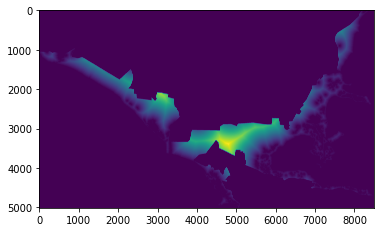

<AxesSubplot:>

In [33]:
show(src.read(9)) #f8 distance to water

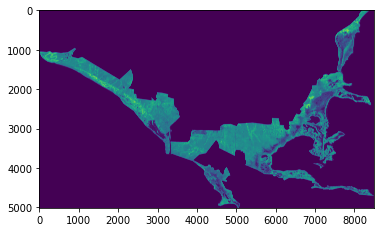

<AxesSubplot:>

In [34]:
show(src.read(8)) #f7 vegetation

# Feature Selection with XGBoost

In [16]:
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from sklearn.metrics import accuracy_score

In [17]:
# Fit model using each importance as a threshold
thresholds = sort(xgb_model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_x_train, y_train)
    # eval model
    select_x_test = selection.transform(x_test)
    y_pred = selection_model.predict(select_x_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_x_train.shape[1], accuracy*100.0))

Thresh=0.007, n=9, Accuracy: 95.93%
Thresh=0.010, n=8, Accuracy: 95.87%
Thresh=0.015, n=7, Accuracy: 95.85%
Thresh=0.018, n=6, Accuracy: 95.82%
Thresh=0.026, n=5, Accuracy: 95.74%
Thresh=0.074, n=4, Accuracy: 95.65%
Thresh=0.138, n=3, Accuracy: 94.46%
Thresh=0.250, n=2, Accuracy: 94.16%
Thresh=0.463, n=1, Accuracy: 90.43%


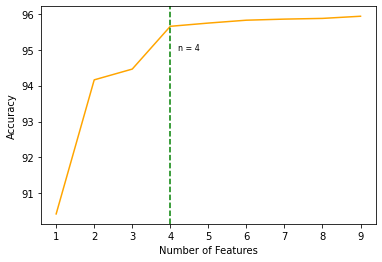

In [18]:
num_of_features = np.arange(1, 10)
accuarcy = [90.43, 94.16, 94.46, 95.65, 95.74, 95.82, 95.85, 95.87, 95.93]

plt.plot(num_of_features, accuarcy, color = 'orange')
plt.ylabel("Accuracy")
plt.xlabel("Number of Features")
plt.axvline(4, color='green', linestyle='dashed')
plt.text(4.2, 95, 'n = 4', fontsize=8); #n=4 seems decent, n=6 may be a good choice